# Imports

In [6]:
import sys
sys.path.append("../Face Detection")

import cv2
import glob
import importlib
import os
import zipfile


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from face_detection import predict_detected_faces
from PIL import Image
from keras import initializers, regularizers, Sequential
from keras.applications import EfficientNetB0, InceptionV3, MobileNet, MobileNetV2, ResNet50, VGG16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import (
    AveragePooling2D, BatchNormalization, Conv2D, Dense, Dropout,
    Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D,
    SpatialDropout2D
)
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [3]:
batch_size = 24
target_size = (224, 224)
learning_rate = 0.0001
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Data Augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 6400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Plotting a batch of training data

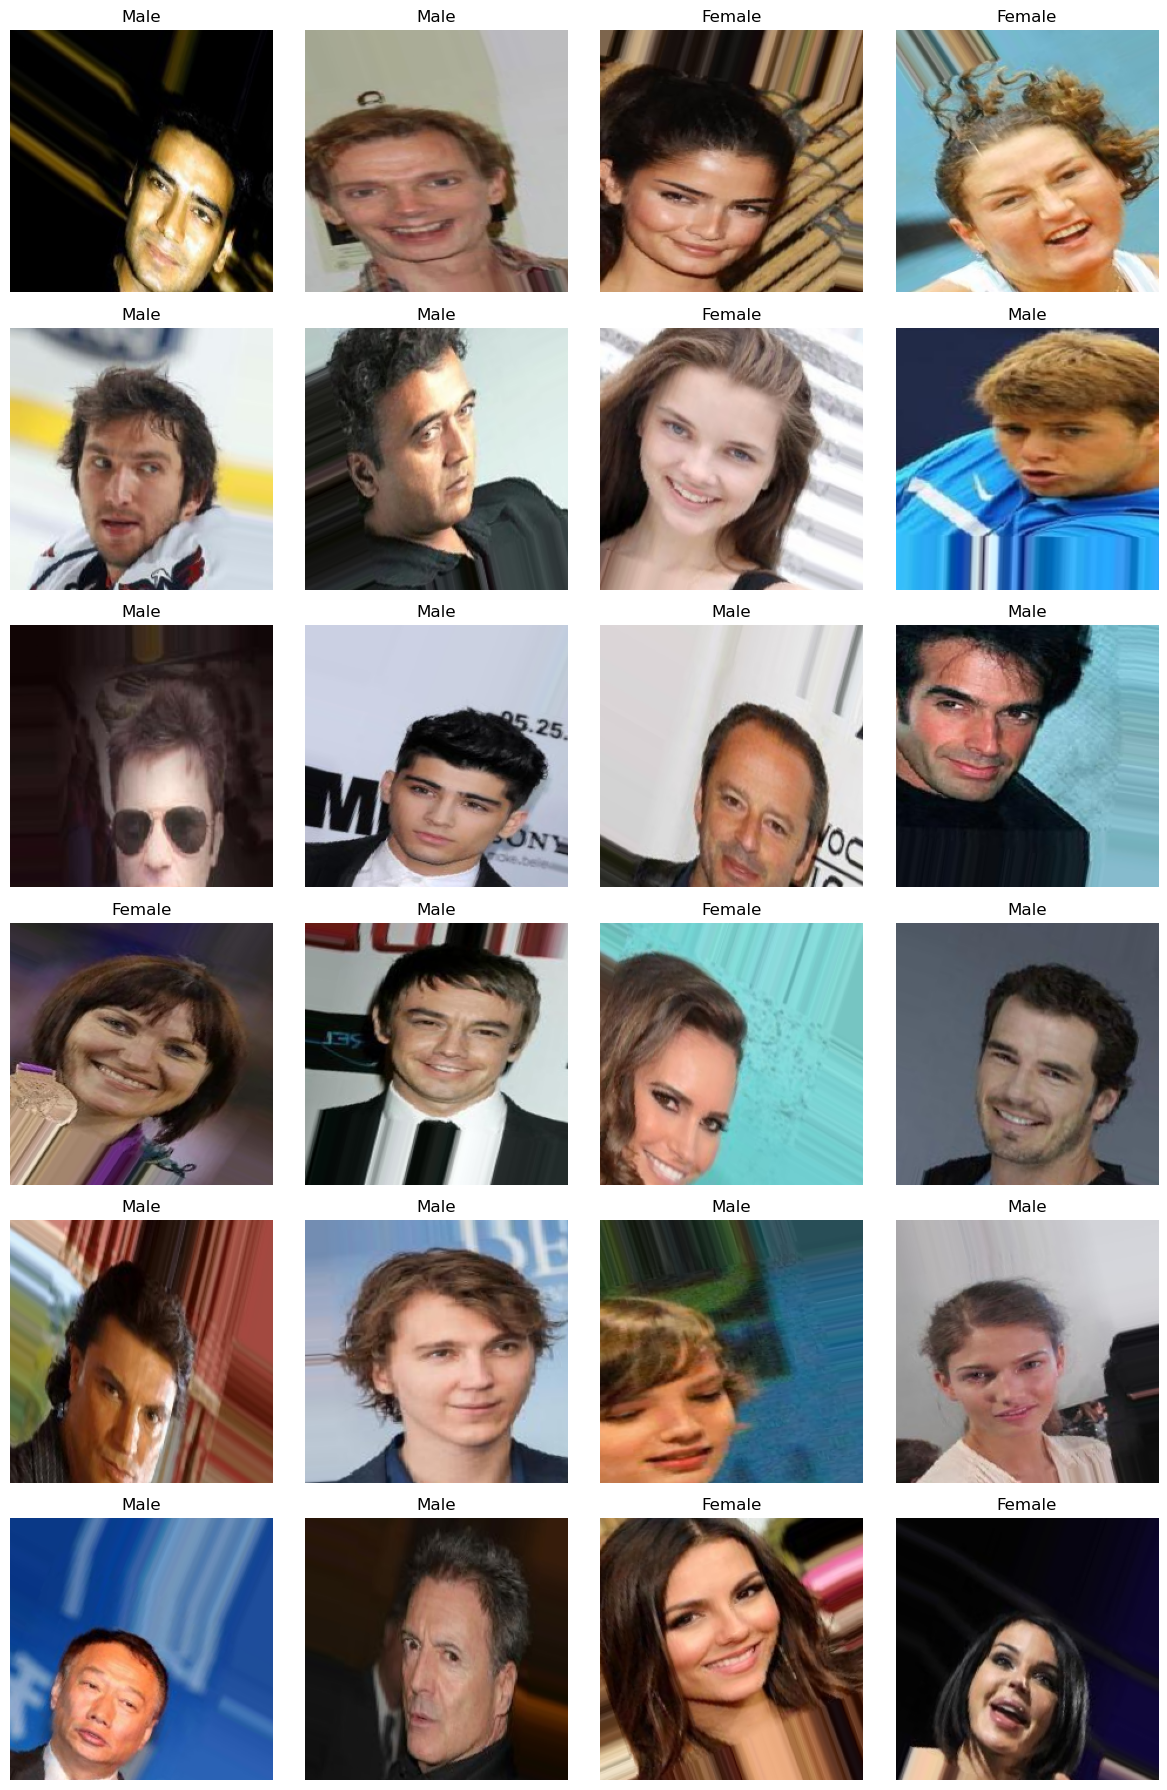

In [5]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    label = "Female" if y_batch[i] == 0 else "Male"
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [6]:
model = Sequential([
    Conv2D(32, kernel_s, activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001), padding="VALID"),
    MaxPooling2D((2,2)),

    Conv2D(64, kernel_s, activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, kernel_s, activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, kernel_s, activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, kernel_s, activation='relu'),
    MaxPooling2D((2,2)),

    # Last layer decise -> preparation for this = some layers before
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

2025-05-11 07:54:21.026538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46654 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6


# Compile the model and start the training

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=40,
    validation_data=valid_gen,
    steps_per_epoch=100,
    callbacks=[early_stopping]
)

Epoch 1/40


2025-05-11 07:54:27.202153: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-11 07:54:29.120907: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcf7c4b4860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-11 07:54:29.120944: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-11 07:54:29.126904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746950069.271633   10347 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 28s 223ms/step - loss: 0.6996 - acc: 0.5284 - val_loss: 0.6837 - val_acc: 0.5987
Epoch 2/40
100/100 [==============================] - 22s 222ms/step - loss: 0.6983 - acc: 0.5025 - val_loss: 0.7002 - val_acc: 0.5000
Epoch 3/40
100/100 [==============================] - 23s 226ms/step - loss: 0.6944 - acc: 0.5542 - val_loss: 0.6979 - val_acc: 0.5000
Epoch 4/40
100/100 [==============================] - 22s 224ms/step - loss: 0.6860 - acc: 0.5600 - val_loss: 0.7013 - val_acc: 0.5000
Epoch 5/40
100/100 [==============================] - 23s 226ms/step - loss: 0.6973 - acc: 0.4992 - val_loss: 0.6938 - val_acc: 0.5525
Epoch 6/40
100/100 [==============================] - 22s 221ms/step - loss: 0.6806 - acc: 0.5896 - val_loss: 0.6234 - val_acc: 0.6612
Epoch 7/40
100/100 [==============================] - 23s 226ms/step - loss: 0.6143 - acc: 0.6802 - val_loss: 0.6070 - val_acc: 0.6762
Epoch 8/40
100/100 [==============================] - 22s 223ms/st

# Plot the results of the training

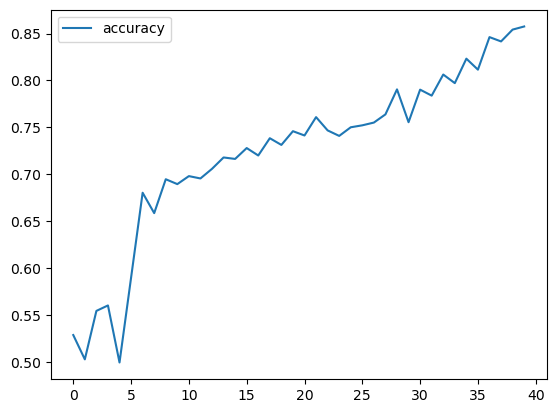

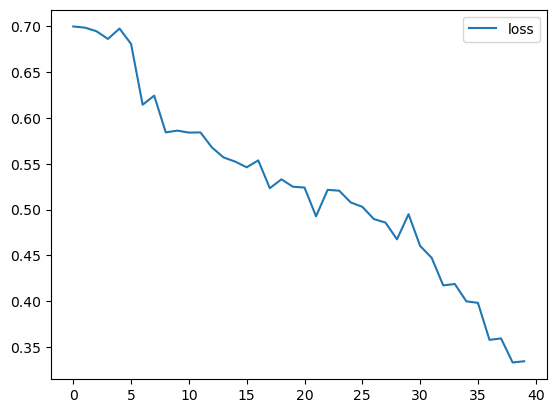

In [8]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 0s 129ms/step


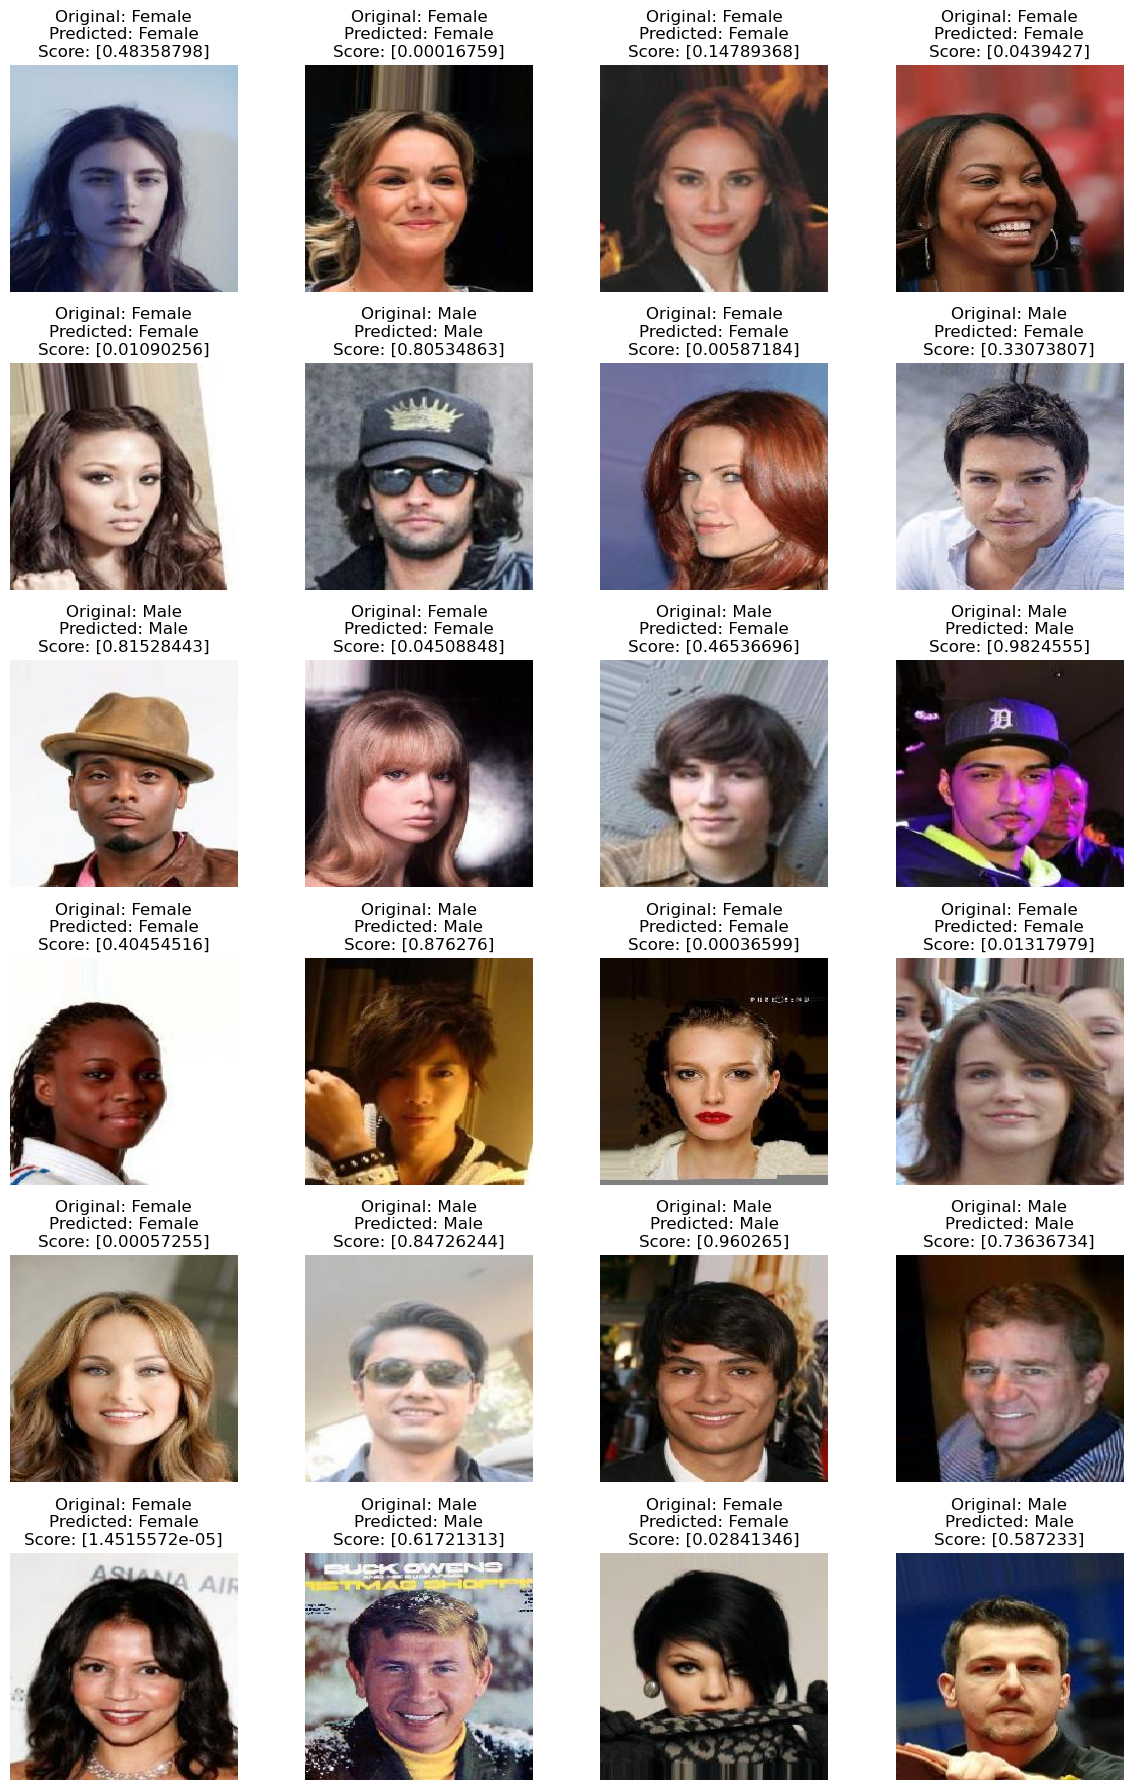

In [9]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

# print(f"Predictions {predictions}")
predicted_labels = (predictions > 0.5).astype(int).flatten()
# print(predicted_labels)

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

class_names = ["Female", "Male"]

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    true_label = class_names[int(y_batch[i])]
    predicted_label = class_names[predicted_labels[i]]
    
    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {predictions[i]}")
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 0s 149ms/step


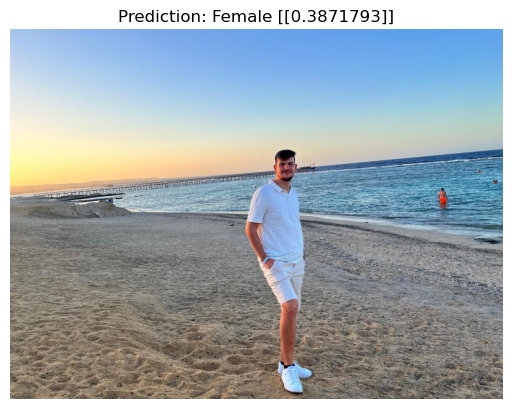

1/1 [==============================] - 0s 22ms/step


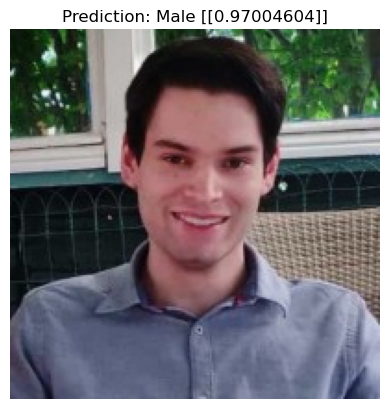

1/1 [==============================] - 0s 22ms/step


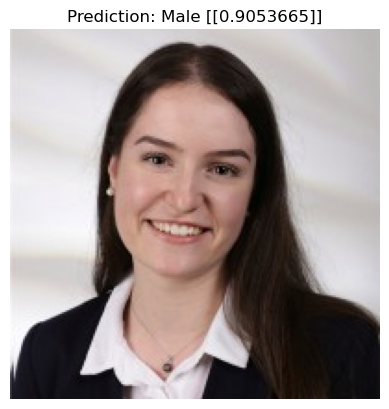

1/1 [==============================] - 0s 24ms/step


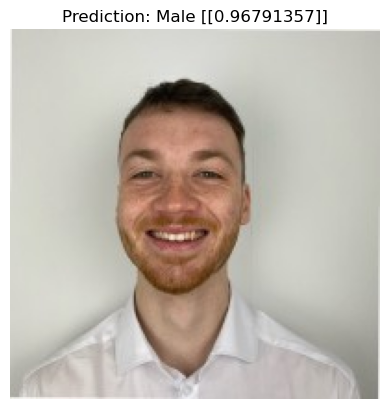

In [10]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

class_names = ["Female", "Male"]

images = glob.glob('../Images/*.jpg')

for i, image in enumerate(images):
    img_array = edit_image(image)
    
    prediction = model.predict(img_array)
    predicted_labels = (prediction > 0.5).astype(int).flatten()
    predicted_label = class_names[predicted_labels[0]]

    plt.imshow(load_img(image))
    plt.title(f"Prediction: {predicted_label} {prediction}")
    plt.axis("off")
    plt.show()

# Evaluate the model ans save it to a file

In [11]:
model.evaluate(test_gen)
model.save("../Models/Gender_classification.keras")

34/34 [==============================] - 1s 35ms/step - loss: 0.2684 - acc: 0.8825


# Test the model on detected and extracted faces

Model not defined or not a Sequential model – loading from file...


2025-05-11 08:58:38.662509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46654 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
2025-05-11 08:58:41.922344: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 1s 736ms/step


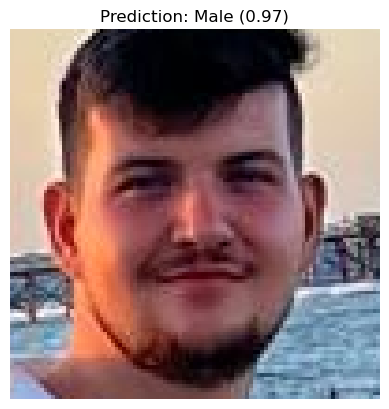

1/1 [==============================] - 0s 25ms/step


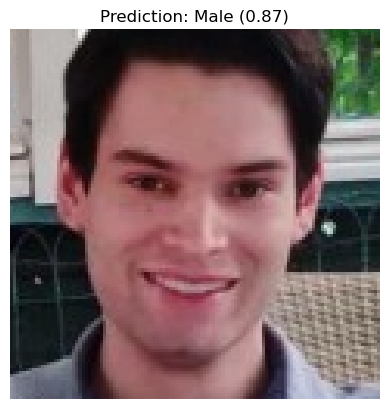

1/1 [==============================] - 0s 23ms/step


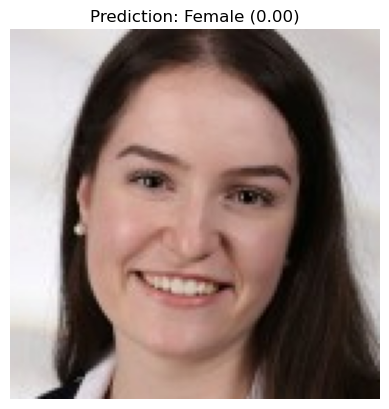

1/1 [==============================] - 0s 27ms/step


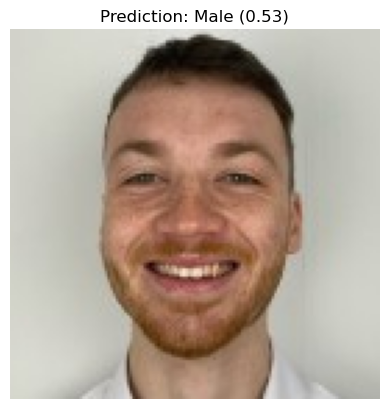

In [4]:
try:
    model
except NameError:
    model = None

if not isinstance(model, Sequential):
    print("Model not defined or not a Sequential model – loading from file...")
    model = load_model("../Models/Gender_classification.keras")

predict_detected_faces(model=model, class_names=["Female", "Male"])